### Runners

In [4]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import soundfile as sf
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm



In [5]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from collections import defaultdict
import soundfile as sf
from scipy import signal

# --------------------------
# Phase 1: Spectrum Sensing
# --------------------------

def load_and_extract_features(data_path, sr=22050, duration=3):
    """Load audio files and extract MFCC features with labels."""
    features = []
    labels = []
    
    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            continue
            
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            try:
                audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                mfccs_mean = np.mean(mfccs.T, axis=0)
                features.append(mfccs_mean)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return np.array(features), np.array(labels)

# Load datasets
bio_features, bio_labels = load_and_extract_features("data/biophonic")
geo_features, geo_labels = load_and_extract_features("data/geophonic")

# Simulate anthropogenic noise (since we don't have real data)
def generate_anthro_noise(num_samples=100):
    """Generate synthetic ship/engine noise (50-500Hz dominant)"""
    anthro_features = []
    for _ in range(num_samples):
        noise = np.random.uniform(-0.1, 0.1, 22050*3)
        # Add low-frequency components
        noise += 0.5 * np.sin(2 * np.pi * 100 * np.linspace(0, 3, 22050*3))
        mfccs = librosa.feature.mfcc(y=noise, sr=22050, n_mfcc=40)
        anthro_features.append(np.mean(mfccs.T, axis=0))
    return np.array(anthro_features)

anthro_features = generate_anthro_noise()
anthro_labels = np.array(['ship'] * len(anthro_features))

# Combine all data
X = np.concatenate((bio_features, geo_features, anthro_features))
y = np.concatenate((bio_labels, geo_labels, anthro_labels))

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train classifier
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y_encoded, epochs=30, batch_size=32, validation_split=0.2)

# --------------------------
# Phase 2: Spectrum Decision
# --------------------------

def analyze_frequency_occupancy(audio, sr=22050):
    """Calculate energy distribution across frequency bands"""
    freqs = np.fft.rfftfreq(len(audio), d=1/sr)
    fft = np.abs(np.fft.rfft(audio))
    
    # Define marine acoustic bands (Hz)
    bands = {
        'infrasonic': (1, 20),
        'low': (20, 500),
        'mid': (500, 20000),
        'high': (20000, 40000)
    }
    
    band_energy = {}
    for name, (low, high) in bands.items():
        mask = (freqs >= low) & (freqs <= high)
        band_energy[name] = np.sum(fft[mask])
    
    return band_energy

def allocate_bands(sound_type, band_energy):
    """Assign frequency bands based on source type and current occupancy"""
    allocation = {}
    
    if sound_type == 'dolphin':  # Priority to marine mammals
        allocation['primary'] = 'mid'
        allocation['secondary'] = 'high'
    elif sound_type == 'earthquake':
        allocation['primary'] = 'infrasonic'
    elif sound_type == 'ship':
        # Avoid mid-band if bioacoustics are active
        if band_energy['mid'] > 0.5 * band_energy['low']:
            allocation['primary'] = 'low'
        else:
            allocation['primary'] = 'mid'
    
    return allocation

# --------------------------
# Phase 3: Spectrum Sharing
# --------------------------

class SpectrumCoordinator:
    def __init__(self):
        self.allocations = defaultdict(list)
        self.time_slots = np.linspace(0, 1, 10)  # 10 time slots
    
    def add_source(self, sound_type, audio):
        # Classify source
        features = np.mean(librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40).T, axis=0)
        pred = model.predict(features.reshape(1, -1))
        sound_class = le.inverse_transform([np.argmax(pred)])[0]
        
        # Analyze spectrum
        band_energy = analyze_frequency_occupancy(audio)
        
        # Allocate bands
        allocation = allocate_bands(sound_class, band_energy)
        
        # Assign time slot to minimize interference
        slot = self.find_optimal_slot(sound_class, allocation['primary'])
        self.allocations[slot].append({
            'type': sound_class,
            'band': allocation['primary'],
            'audio': audio
        })
        return slot
    
    def find_optimal_slot(self, sound_type, band):
        """Find time slot with least conflicting sources in same band"""
        slot_conflicts = []
        for slot in self.time_slots:
            conflicts = sum(
                1 for alloc in self.allocations[slot] 
                if alloc['band'] == band and alloc['type'] != sound_type
            )
            slot_conflicts.append(conflicts)
        return self.time_slots[np.argmin(slot_conflicts)]

# --------------------------
# Simulation & Visualization
# --------------------------

def simulate_environment():
    coordinator = SpectrumCoordinator()
    
    # Load sample sounds
    dolphin_audio, _ = librosa.load("data/biophonic/dolphin/sample1.wav", sr=22050, duration=3)
    quake_audio, _ = librosa.load("data/geophonic/earthquake/sample1.mp3", sr=22050, duration=3)
    ship_audio = np.random.uniform(-0.1, 0.1, 22050*3)  # Simulated
    
    # Add sources to coordinator
    print("Allocating dolphin... Slot:", coordinator.add_source('dolphin', dolphin_audio))
    print("Allocating earthquake... Slot:", coordinator.add_source('earthquake', quake_audio))
    print("Allocating ship... Slot:", coordinator.add_source('ship', ship_audio))
    
    # Visualize allocations
    plt.figure(figsize=(10, 4))
    for slot, allocs in coordinator.allocations.items():
        for alloc in allocs:
            plt.scatter(slot, alloc['band'], label=f"{alloc['type']} ({alloc['band']})")
    plt.yticks([0, 1, 2, 3], ['infrasonic', 'low', 'mid', 'high'])
    plt.xlabel("Time slot")
    plt.title("Spectrum Allocation Over Time")
    plt.legend()
    plt.show()

simulate_environment()

FileNotFoundError: [Errno 2] No such file or directory: 'data/biophonic'

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Preprocessing
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing of audio datasets"""
    
    def __init__(self, target_sr=22050, duration=5, n_mfcc=40):
        self.target_sr = target_sr
        self.duration = duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        
    def load_dataset(self, root_path):
        """Load audio files from nested folder structure"""
        features = []
        labels = []
        file_paths = []
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    audio, sr = librosa.load(file_path, 
                                           sr=self.target_sr, 
                                           duration=self.duration)
                    features.append(self.extract_features(audio))
                    labels.append(label)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
        
        return np.array(features), np.array(labels), file_paths
    
    def extract_features(self, audio):
        """Extract comprehensive audio features"""
        features = []
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
        features.extend(np.mean(mfccs, axis=1))
        features.extend(np.std(mfccs, axis=1))
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            *np.mean(spectral_contrast, axis=1)
        ])
        
        # Temporal features
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
        rmse = librosa.feature.rms(y=audio)
        features.extend([
            np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
            np.mean(rmse), np.std(rmse)
        ])
        
        return features
    
    def preprocess_data(self, X, y):
        """Encode labels and scale features"""
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Model Architecture
# --------------------------

class BioGeoClassifier:
    """Advanced classifier for biophonic and geophonic sounds"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        """Construct neural network with attention mechanism"""
        inputs = layers.Input(shape=input_shape)
        
        # Feature processing
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Attention layer
        attention = layers.Dense(256, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(512)(attention)
        attention = layers.Permute([2, 1])(attention)
        
        x = layers.Multiply()([x, attention])
        
        # Output
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train model with early stopping"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )
        
        return history

# --------------------------
# 3. Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Handles performance visualization and analysis"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        plt.figure(figsize=(15, 5))
        
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Plot detailed confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    @staticmethod
    def plot_spectrogram(audio_path, sr=22050):
        """Visualize spectrogram of a sample audio"""
        y, sr = librosa.load(audio_path, sr=sr)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max),
                                sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.show()

# --------------------------
# 4. Spectrum Management System
# --------------------------

class SpectrumManager:
    """Handles spectrum allocation and sharing"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),         # Hurricanes
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        
    def analyze_audio(self, audio):
        """Classify audio and analyze frequency content"""
        # Extract features
        loader = AudioDataLoader()
        features = loader.extract_features(audio)
        features = np.array(features).reshape(1, -1)
        
        # Classify
        pred = self.classifier.predict(features)
        class_idx = np.argmax(pred)
        sound_class = self.label_encoder[class_idx]
        
        # Frequency analysis
        freqs = np.fft.rfftfreq(len(audio), d=1/22050)
        fft = np.abs(np.fft.rfft(audio))
        
        band_energy = {}
        for band, (low, high) in self.band_allocation.items():
            mask = (freqs >= low) & (freqs <= high)
            band_energy[band] = np.sum(fft[mask])
        
        return sound_class, band_energy
    
    def allocate_band(self, sound_class, band_energy):
        """Determine optimal frequency band allocation"""
        allocation = {}
        
        # Priority rules
        if sound_class in ['dolphin', 'whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Avoid mid-band if already occupied
            if band_energy['mid'] > 0.3 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        
        return allocation
    
    def visualize_allocation(self):
        """Plot current spectrum allocations"""
        plt.figure(figsize=(10, 6))
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(alloc['class'], 
                     width=band_range[1]-band_range[0],
                     left=band_range[0],
                     alpha=0.6,
                     label=f"{alloc['class']} ({alloc['band']})")
        
        plt.title('Current Spectrum Allocation')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

# --------------------------
# 5. Main Execution
# --------------------------

def main():
    # 1. Load and preprocess data
    print("Loading datasets...")
    loader = AudioDataLoader()
    
    # Load biophonic data
    bio_X, bio_y, bio_paths = loader.load_dataset("/Users/fatbatman/Develop/Liquid Neural Network/dataset")
    
    # Load geophonic data
    geo_X, geo_y, geo_paths = loader.load_dataset("/Users/fatbatman/Downloads/Dataset")
    
    # Combine datasets
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    # Preprocess
    X_scaled, y_categorical, class_names = loader.preprocess_data(X, y)
    
    # 2. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, test_size=0.2, random_state=42
    )
    
    # 3. Train model
    print("\nTraining model...")
    classifier = BioGeoClassifier(input_shape=(X_train.shape[1],), 
                                num_classes=len(class_names))
    history = classifier.train(X_train, y_train, 
                             X_test, y_test, 
                             epochs=100)
    
    # 4. Evaluate
    print("\nEvaluating model...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    print(f"\nFinal Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 5. Visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 6. Spectrum Management Demo
    print("\nDemonstrating spectrum management...")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Sample analysis
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        audio, _ = librosa.load(path, sr=22050, duration=5)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"\nSample: {os.path.basename(path)}")
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'energy': band_energy[allocation['primary']]
        })
        
        visualizer.plot_spectrogram(path)
    
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    main()

Loading datasets...
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Atlantic Spotted Dolphin (Stenella frontalis)/.DS_Store: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/59005002_rms.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/5601700B_stft.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/56018003_rms.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/56028001_chroma.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/5601601O_spectral_contrast.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neural Network/dataset/Northern Right Whale (Eubalaena glacialis)/5601700U_rms.npy: 
Error loading /Users/fatbatman/Develop/Liquid Neu

KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Enhanced Data Loading & Preprocessing
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing of audio datasets with robust error handling"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        
    def is_audio_file(self, filename):
        """Check if file has supported audio extension"""
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        """Load audio file with proper error handling and duration management"""
        try:
            # Get file duration to handle variable-length files
            duration = librosa.get_duration(filename=file_path)
            duration = min(duration, self.max_duration)
            
            # Load with correct duration handling
            audio, sr = librosa.load(
                file_path,
                sr=self.target_sr,
                duration=duration,
                mono=True  # Force conversion to mono if needed
            )
            
            # If audio is shorter than max_duration, pad with zeros
            if len(audio) < self.target_sr * self.max_duration:
                padding = self.target_sr * self.max_duration - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')
                
            return audio, True
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path):
        """Load audio files from nested folder structure with proper filtering"""
        features = []
        labels = []
        file_paths = []
        error_count = 0
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"Processing category: {label}")
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                file_path = os.path.join(label_path, file)
                audio, success = self.load_audio_file(file_path)
                
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    extracted_features = self.extract_features(audio)
                    if extracted_features is not None:
                        features.append(extracted_features)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        print(f"Completed loading. Total errors: {error_count}")
        return np.array(features), np.array(labels), file_paths
    
    def extract_features(self, audio):
        """Extract comprehensive audio features with robustness checks"""
        try:
            features = []
            
            # MFCCs with delta features
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            features.extend(np.mean(mfccs, axis=1))
            features.extend(np.std(mfccs, axis=1))
            features.extend(np.mean(delta_mfccs, axis=1))
            features.extend(np.mean(delta2_mfccs, axis=1))
            
            # Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1),
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1))
            features.extend(np.std(chroma, axis=1))
            
            return features
        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return None
    
    def preprocess_data(self, X, y):
        """Encode labels and scale features with validation"""
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Enhanced Model Architecture
# --------------------------

class BioGeoClassifier:
    """Advanced classifier with improved architecture"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_enhanced_model(input_shape, num_classes)
        
    def build_enhanced_model(self, input_shape, num_classes):
        """Construct improved neural network with residual connections"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Residual block 1
        residual = x
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(256, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(512)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Residual block 2
        residual = x
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        
        # Custom optimizer configuration
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Enhanced training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

# --------------------------
# 3. Enhanced Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

# --------------------------
# 5. Main Execution with Enhanced Features
# --------------------------

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # 1. Initialize data loader with enhanced parameters
    loader = AudioDataLoader(
        target_sr=44100,  # Higher sampling rate for better frequency resolution
        max_duration=4,   # Slightly shorter for more consistent samples
        n_mfcc=60        # More MFCC coefficients for better feature representation
    )
    
    # 2. Load datasets with progress feedback
    print("\nLoading biophonic dataset...")
    bio_X, bio_y, bio_paths = loader.load_dataset("/Users/fatbatman/Develop/Liquid Neural Network/dataset")
    
    print("\nLoading geophonic dataset...")
    geo_X, geo_y, geo_paths = loader.load_dataset("/Users/fatbatman/Downloads/Dataset")
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with enhanced architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,  # Increased epochs for better convergence
        batch_size=64  # Larger batch size for stability
    )
    
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    import tensorflow as tf
    main()

=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset...
Processing category: Bearded Seal (Erignathus barbatus)
Processing category: Bottlenose Dolphin (Tursiops truncatus
Processing category: Atlantic Spotted Dolphin (Stenella frontalis)
Processing category: Northern Right Whale (Eubalaena glacialis)
Processing category: Rough-Toothed Dolphin (Steno bredanensis)
Processing category: Walrus (Odobenus rosmarus)
Processing category: False Killer Whale (Pseudorca crassidens)
Processing category: Finback Whale (Balaenoptera physalus)
Processing category: Best of Beluga, White Whale (Delphinapterus leucas)
Processing category: Spinner Dolphin (Stenella longirostris)
Processing category: Bowhead Whale (Balaena mysticetus)
Processing category: Common Dolphin (Delphinus delphis)
Processing category: Pantropical Spotted Dolphin (Stenella attenuata)
Processing category: Ross Seal (Ommatophoca rossi)
Processing category: Sperm Whale (Physeter macrocephalus
Proc

KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import warnings
import time
from pydub import AudioSegment
import soundfile as sf
warnings.filterwarnings('ignore')

# --------------------------
# 1. Enhanced Data Loading & Preprocessing with Multi-Format Support
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing of audio datasets with robust error handling"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.mp4', '.WAV', '.MP3', '.MP4')
        
    def is_audio_file(self, filename):
        """Check if file has supported audio extension"""
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        """Load audio file with proper error handling and duration management"""
        try:
            # First try librosa for most formats
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
            except:
                # Fallback to pydub for problematic files
                audio_segment = AudioSegment.from_file(file_path)
                audio = np.array(audio_segment.get_array_of_samples())
                if audio_segment.channels > 1:
                    audio = audio[::audio_segment.channels]  # Convert to mono
                sr = audio_segment.frame_rate
                
                # Resample if needed
                if sr != self.target_sr:
                    audio = librosa.resample(audio.astype(float), orig_sr=sr, target_sr=self.target_sr)
                
                # Trim to max_duration
                max_samples = self.target_sr * self.max_duration
                if len(audio) > max_samples:
                    audio = audio[:max_samples]
            
            # Pad if needed
            if len(audio) < self.target_sr * self.max_duration:
                padding = self.target_sr * self.max_duration - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')
                
            return audio, True
        
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path):
        """Load audio files from nested folder structure with proper filtering"""
        features = []
        labels = []
        file_paths = []
        error_count = 0
        total_files = 0
        
        # First count total files
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += len([f for f in os.listdir(label_path) if self.is_audio_file(f)])
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                
                # Show progress
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} "
                          f"({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    extracted_features = self.extract_features(audio)
                    if extracted_features is not None:
                        features.append(extracted_features)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return np.array(features), np.array(labels), file_paths
    
    def extract_features(self, audio):
        """Extract comprehensive audio features with robustness checks"""
        try:
            features = []
            
            # MFCCs with delta features
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            features.extend(np.mean(mfccs, axis=1))
            features.extend(np.std(mfccs, axis=1))
            features.extend(np.mean(delta_mfccs, axis=1))
            features.extend(np.mean(delta2_mfccs, axis=1))
            
            # Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1),
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1))
            features.extend(np.std(chroma, axis=1))
            
            return features
        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return None
    
    def preprocess_data(self, X, y):
        """Encode labels and scale features with validation"""
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Enhanced Model Architecture
# --------------------------

class BioGeoClassifier:
    """Advanced classifier with improved architecture"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_enhanced_model(input_shape, num_classes)
        
    def build_enhanced_model(self, input_shape, num_classes):
        """Construct improved neural network with residual connections"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Residual block 1
        residual = x
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(256, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(512)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Residual block 2
        residual = x
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        
        # Custom optimizer configuration
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Enhanced training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

# --------------------------
# 3. Enhanced Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

# --------------------------
# 5. Main Execution with Enhanced Features
# --------------------------

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # 1. Initialize data loader with enhanced parameters
    loader = AudioDataLoader(
        target_sr=44100,  # Higher sampling rate for better frequency resolution
        max_duration=4,   # Slightly shorter for more consistent samples
        n_mfcc=60        # More MFCC coefficients for better feature representation
    )
    
    # 2. Load datasets with progress feedback
    print("\nLoading biophonic dataset...")
    bio_X, bio_y, bio_paths = loader.load_dataset("/Users/fatbatman/Develop/Liquid Neural Network/dataset")
    
    print("\nLoading geophonic dataset...")
    geo_X, geo_y, geo_paths = loader.load_dataset("/Users/fatbatman/Downloads/Dataset")
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with enhanced architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,  # Increased epochs for better convergence
        batch_size=64  # Larger batch size for stability
    )
    
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    import tensorflow as tf
    main()

=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset...

Processing category: Bearded Seal (Erignathus barbatus)...
  Progress: 10/721 (132.4s remaining)
  Progress: 20/721 (129.9s remaining)
  Progress: 30/721 (150.7s remaining)
  Progress: 40/721 (168.5s remaining)
  Progress: 50/721 (178.7s remaining)

Processing category: Bottlenose Dolphin (Tursiops truncatus...
  Progress: 60/721 (182.7s remaining)
  Progress: 70/721 (187.2s remaining)

Processing category: Atlantic Spotted Dolphin (Stenella frontalis)...
  Progress: 80/721 (185.6s remaining)
  Progress: 90/721 (185.9s remaining)
  Progress: 100/721 (183.2s remaining)
  Progress: 110/721 (183.8s remaining)
  Progress: 120/721 (184.6s remaining)
  Progress: 130/721 (181.8s remaining)

Processing category: Northern Right Whale (Eubalaena glacialis)...

Processing category: Rough-Toothed Dolphin (Steno bredanensis)...

Processing category: Walrus (Odobenus rosmarus)...

Processing category: False 

ValueError: Inputs have incompatible shapes. Received shapes (1, 256) and (1, 512)

In [6]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import warnings
import time
import soundfile as sf
import joblib  # For saving scaler and label encoder
warnings.filterwarnings('ignore')
import hashlib

# --------------------------
# 1. Enhanced Data Loading & Preprocessing with NPY Caching
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing of audio datasets with NPY caching"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40, cache_dir='./cache'):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path, suffix):
        """Generate cache file path based on dataset path"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"{root_hash}_{suffix}")
        
    def is_audio_file(self, filename):
        """Check if file has supported audio extension"""
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        """Load audio file with proper error handling"""
        try:
            # Try librosa first
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
                return audio, True
            except:
                # Fallback to soundfile
                try:
                    with sf.SoundFile(file_path) as f:
                        duration = min(len(f) / f.samplerate, self.max_duration)
                        target_frames = int(duration * self.target_sr)
                        audio = f.read(frames=target_frames, dtype='float32', always_2d=True)
                        if audio.ndim > 1 and audio.shape[1] > 1:
                            audio = np.mean(audio, axis=1)
                        else:
                            audio = audio.flatten()
                        if f.samplerate != self.target_sr:
                            audio = librosa.resample(audio, orig_sr=f.samplerate, target_sr=self.target_sr)
                        return audio, True
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    return None, False
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path, use_cache=True):
        """Load audio files with NPY caching"""
        # Cache files
        features_cache = self._get_cache_path(root_path, "features.npy")
        labels_cache = self._get_cache_path(root_path, "labels.npy")
        paths_cache = self._get_cache_path(root_path, "paths.npy")
        
        # Try to load from cache
        if use_cache and all(os.path.exists(f) for f in [features_cache, labels_cache, paths_cache]):
            try:
                print(f"Loading cached data from {features_cache}")
                features = np.load(features_cache)
                labels = np.load(labels_cache)
                file_paths = np.load(paths_cache, allow_pickle=True)
                return features, labels, file_paths
            except Exception as e:
                print(f"Error loading cache: {str(e)}. Reprocessing data.")
        
        # Process data if cache not available
        features = []
        labels = []
        file_paths = []
        error_count = 0
        total_files = 0
        
        # Count total files first
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += len([f for f in os.listdir(label_path) if self.is_audio_file(f)])
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                
                # Show progress
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} "
                          f"({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    extracted_features = self.extract_features(audio)
                    if extracted_features is not None:
                        features.append(extracted_features)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        # Convert to numpy arrays
        features = np.array(features)
        labels = np.array(labels)
        file_paths = np.array(file_paths)
        
        # Save to cache
        if use_cache and len(features) > 0:
            try:
                np.save(features_cache, features)
                np.save(labels_cache, labels)
                np.save(paths_cache, file_paths)
                print(f"Saved processed data to cache: {features_cache}")
            except Exception as e:
                print(f"Error saving cache: {str(e)}")
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return features, labels, file_paths

    def extract_features(self, audio):
        """Extract comprehensive audio features"""
        try:
            features = []
            
            # MFCCs with delta features
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            features.extend(np.mean(mfccs, axis=1))
            features.extend(np.std(mfccs, axis=1))
            features.extend(np.mean(delta_mfccs, axis=1))
            features.extend(np.mean(delta2_mfccs, axis=1))
            
            # Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1),
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1))
            features.extend(np.std(chroma, axis=1))
            
            return features
        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return None
    
    def preprocess_data(self, X, y, use_cache=True):
        """Encode labels and scale features with caching"""
        cache_prefix = self._get_cache_path("preprocessed", "")
        
        # Try to load from cache
        if use_cache and os.path.exists(cache_prefix + "X_scaled.npy"):
            try:
                print("Loading preprocessed data from cache")
                X_scaled = np.load(cache_prefix + "X_scaled.npy")
                y_categorical = np.load(cache_prefix + "y_categorical.npy")
                self.le = joblib.load(cache_prefix + "label_encoder.joblib")
                scaler = joblib.load(cache_prefix + "scaler.joblib")
                return X_scaled, y_categorical, self.le.classes_
            except Exception as e:
                print(f"Error loading preprocessed cache: {str(e)}. Reprocessing data.")
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Save to cache
        if use_cache:
            try:
                np.save(cache_prefix + "X_scaled.npy", X_scaled)
                np.save(cache_prefix + "y_categorical.npy", y_categorical)
                joblib.dump(self.le, cache_prefix + "label_encoder.joblib")
                joblib.dump(scaler, cache_prefix + "scaler.joblib")
                print("Saved preprocessed data to cache")
            except Exception as e:
                print(f"Error saving preprocessed cache: {str(e)}")
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Fixed Model Architecture
# --------------------------

class BioGeoClassifier:
    """Classifier with fixed architecture to handle shape mismatch"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        """Construct neural network with proper shape handling"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # First residual block (matching dimensions)
        residual = layers.Dense(256)(x)  # Project residual to match dimensions
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(128, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(256)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Second residual block
        residual = x  # No projection needed since dimensions match
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
# --------------------------
# 3. Enhanced Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

# ... [Rest of the code remains the same]

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # 1. Initialize data loader with enhanced parameters
    loader = AudioDataLoader(
        target_sr=44100,
        max_duration=4,
        n_mfcc=60,
        cache_dir='./audio_cache'
    )
    
    # 2. Load datasets with caching
    print("\nLoading biophonic dataset...")
    bio_X, bio_y, bio_paths = loader.load_dataset(
        "/Users/fatbatman/Develop/Liquid Neural Network/dataset",
        use_cache=True
    )
    
    print("\nLoading geophonic dataset...")
    geo_X, geo_y, geo_paths = loader.load_dataset(
        "/Users/fatbatman/Downloads/Dataset",
        use_cache=True
    )
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data with caching
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y, use_cache=True)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with fixed architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,
        batch_size=64
    )
    
    # ... [Rest of the main function remains the same]
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()


if __name__ == "__main__":
    import tensorflow as tf
    main()

=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset...

Processing category: Bearded Seal (Erignathus barbatus)...
  Progress: 10/721 (48.0s remaining)
  Progress: 20/721 (52.2s remaining)
  Progress: 30/721 (54.3s remaining)
  Progress: 40/721 (53.5s remaining)
  Progress: 50/721 (52.7s remaining)

Processing category: Bottlenose Dolphin (Tursiops truncatus...
  Progress: 60/721 (53.0s remaining)
  Progress: 70/721 (51.8s remaining)

Processing category: Atlantic Spotted Dolphin (Stenella frontalis)...
  Progress: 80/721 (50.8s remaining)
  Progress: 90/721 (51.1s remaining)
  Progress: 100/721 (52.5s remaining)
  Progress: 110/721 (56.1s remaining)
  Progress: 120/721 (57.0s remaining)
  Progress: 130/721 (57.7s remaining)

Processing category: Northern Right Whale (Eubalaena glacialis)...

Processing category: Rough-Toothed Dolphin (Steno bredanensis)...

Processing category: Walrus (Odobenus rosmarus)...

Processing category: False Killer Whale 

KeyboardInterrupt: 

### Runners -2

=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/7b081655_max100_features.npy

Loading geophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/1ad7540f_max100_features.npy

Preprocessing data...
Loading preprocessed data from cache

Splitting data...

Training model...
Epoch 1/150
22/22 [==============================] - 1s 20ms/step - loss: 1.8137 - accuracy: 0.5669 - precision: 0.7726 - recall: 0.4717 - auc: 0.8957 - val_loss: 1.2046 - val_accuracy: 0.7209 - val_precision: 0.9024 - val_recall: 0.4302 - val_auc: 0.9690 - lr: 0.0010
Epoch 2/150
22/22 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.8408 - precision: 0.8941 - recall: 0.7972 - auc: 0.9911 - val_loss: 0.7282 - val_accuracy: 0.8372 - val_precision: 0.9274 - val_recall: 0.6686 - val_auc: 0.9855 - lr: 0.0010
Epoch 3/150
22/22 [==============================

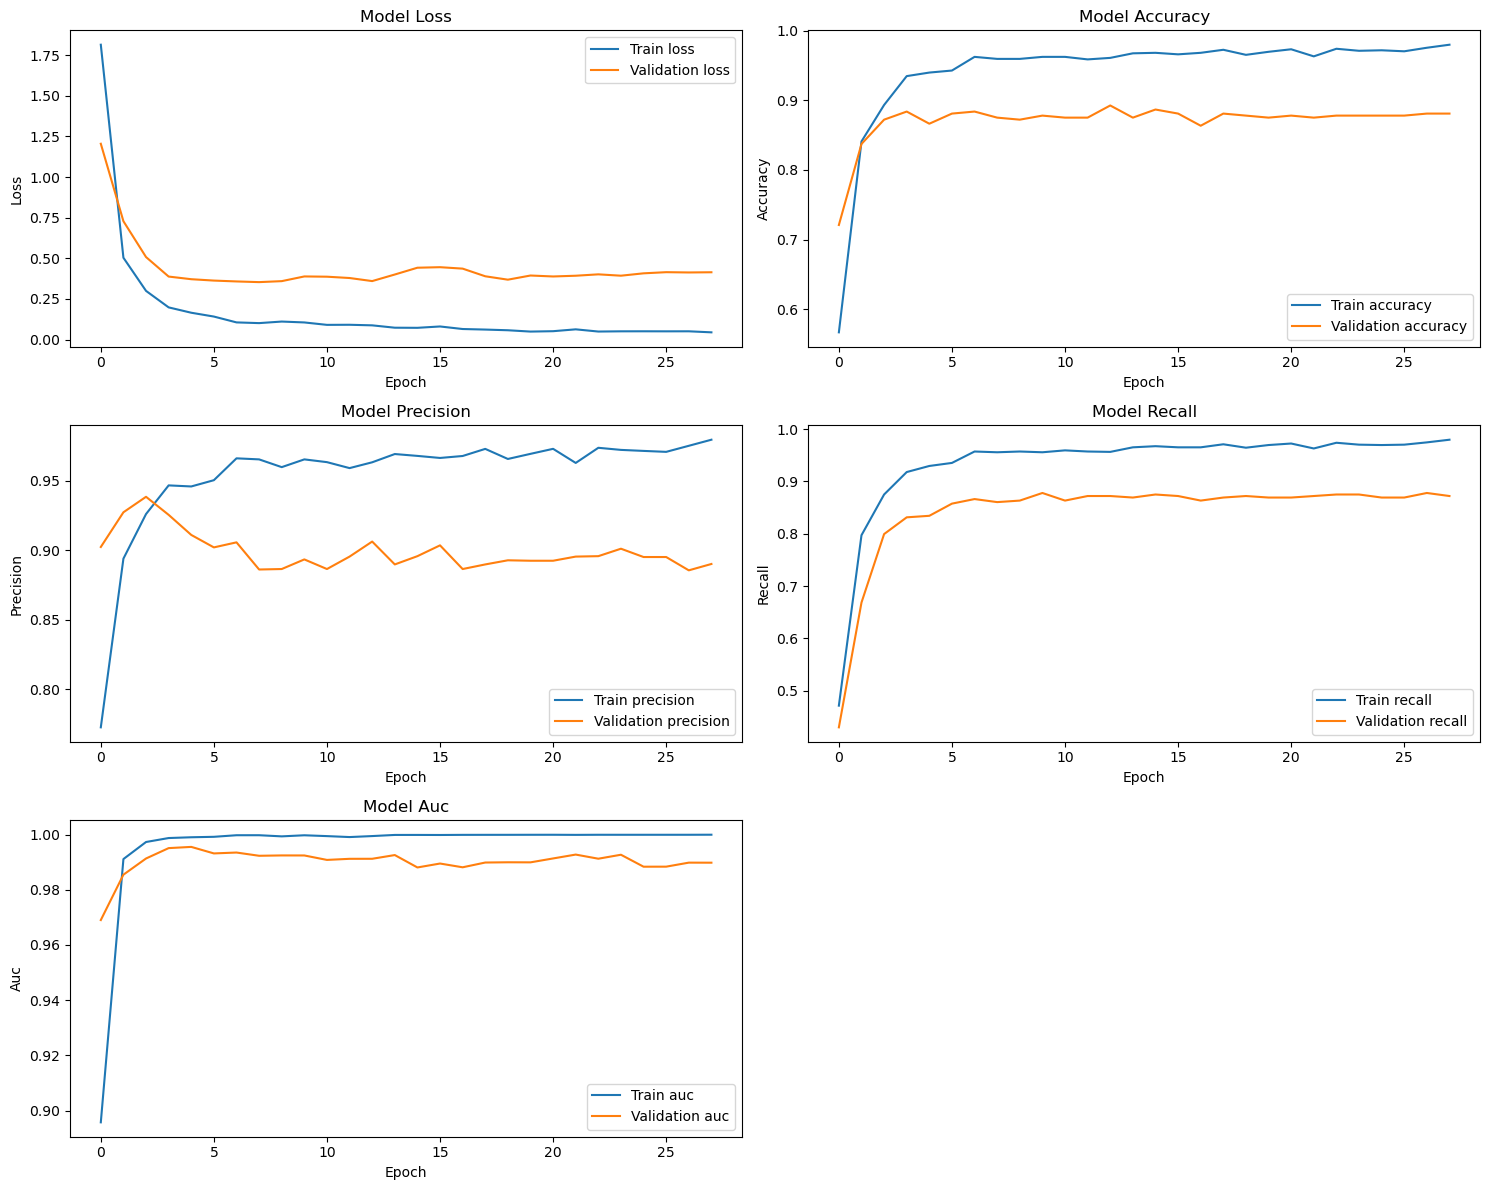

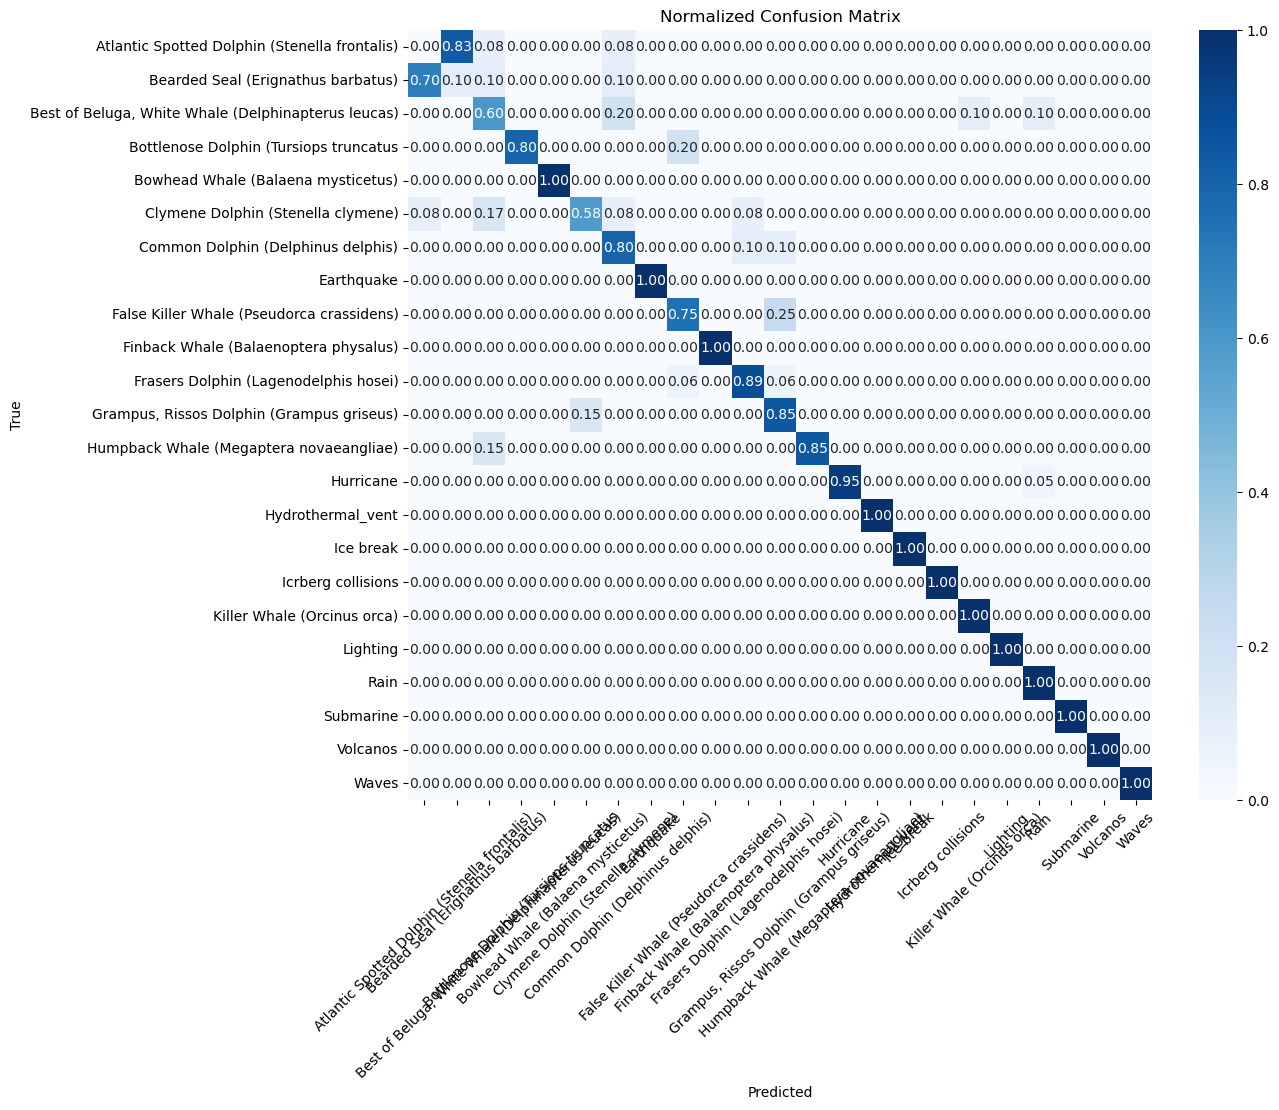


=== Spectrum Management Demonstration ===

Analyzing: 91013004.wav
Analysis error: Graph execution error:

Detected at node 'model_1/dense_13/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/h

In [13]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import warnings
import time
import soundfile as sf
import joblib
import hashlib
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Preprocessing with File Limiting
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing with limit on files per category"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40, cache_dir='./cache', max_files_per_category=100):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        self.cache_dir = cache_dir
        self.max_files = max_files_per_category  # New parameter to limit files
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path, suffix):
        """Generate cache file path with limit parameter in name"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"{root_hash}_max{self.max_files}_{suffix}")
        
    def is_audio_file(self, filename):
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        try:
            # Try librosa first
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
                return audio, True
            except:
                # Fallback to soundfile
                try:
                    with sf.SoundFile(file_path) as f:
                        duration = min(len(f) / f.samplerate, self.max_duration)
                        target_frames = int(duration * self.target_sr)
                        audio = f.read(frames=target_frames, dtype='float32', always_2d=True)
                        if audio.ndim > 1 and audio.shape[1] > 1:
                            audio = np.mean(audio, axis=1)
                        else:
                            audio = audio.flatten()
                        if f.samplerate != self.target_sr:
                            audio = librosa.resample(audio, orig_sr=f.samplerate, target_sr=self.target_sr)
                        return audio, True
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    return None, False
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path, use_cache=True):
        features_cache = self._get_cache_path(root_path, "features.npy")
        labels_cache = self._get_cache_path(root_path, "labels.npy")
        paths_cache = self._get_cache_path(root_path, "paths.npy")
        
        if use_cache and all(os.path.exists(f) for f in [features_cache, labels_cache, paths_cache]):
            try:
                print(f"Loading cached data from {features_cache}")
                return np.load(features_cache), np.load(labels_cache), np.load(paths_cache, allow_pickle=True)
            except Exception as e:
                print(f"Error loading cache: {str(e)}. Reprocessing data.")
        
        features, labels, file_paths = [], [], []
        error_count = 0
        total_files = 0
        
        # Count total files first (for progress tracking)
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += min(len([f for f in os.listdir(label_path) if self.is_audio_file(f)]), 
                                self.max_files)
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            files_processed = 0
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                # Enforce file limit per category
                if files_processed >= self.max_files:
                    break
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                files_processed += 1
                
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} ({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    feature_vector = self.extract_features(audio)
                    if feature_vector is not None:  # Only add if feature extraction succeeded
                        features.append(feature_vector)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        # Verify all features have same length before converting to array
        if features:
            feature_length = len(features[0])
            features = [f for f in features if len(f) == feature_length]
            print(f"Final feature vector length: {feature_length}")
            print(f"Number of valid samples: {len(features)}")
            
            features = np.array(features)
            labels = np.array(labels)
            file_paths = np.array(file_paths)
        else:
            features = np.array([])
            labels = np.array([])
            file_paths = np.array([])
        
        if use_cache and len(features) > 0:
            try:
                np.save(features_cache, features)
                np.save(labels_cache, labels)
                np.save(paths_cache, file_paths)
                print(f"Saved processed data to cache: {features_cache}")
            except Exception as e:
                print(f"Error saving cache: {str(e)}")
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return features, labels, file_paths


    def extract_features(self, audio):
        """Extract comprehensive audio features with consistent length"""
        try:
            features = []
            
            # MFCCs with delta features (always produces n_mfcc coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            # Always take first n_mfcc coefficients for each
            features.extend(np.mean(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.std(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta_mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta2_mfccs, axis=1)[:self.n_mfcc])
            
            # Spectral features (fixed number)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1)[:7],  # First 7 contrast bands
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features (fixed number)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features (fixed 12 bins)
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1)[:12]) # First 12 chroma bins
            features.extend(np.std(chroma, axis=1)[:12])
            
            return features
            
        except librosa.util.exceptions.ParameterError as e:
            print(f"Librosa parameter error in feature extraction: {str(e)}")
            return None
        except ValueError as e:
            print(f"Value error in feature extraction: {str(e)}")
            return None
        except Exception as e:
            print(f"Unexpected error in feature extraction: {str(e)}")
            return None
    
    def preprocess_data(self, X, y, use_cache=True):
        """Encode labels and scale features with caching"""
        cache_prefix = self._get_cache_path("preprocessed", "")
        
        # Try to load from cache
        if use_cache and os.path.exists(cache_prefix + "X_scaled.npy"):
            try:
                print("Loading preprocessed data from cache")
                X_scaled = np.load(cache_prefix + "X_scaled.npy")
                y_categorical = np.load(cache_prefix + "y_categorical.npy")
                self.le = joblib.load(cache_prefix + "label_encoder.joblib")
                scaler = joblib.load(cache_prefix + "scaler.joblib")
                return X_scaled, y_categorical, self.le.classes_
            except Exception as e:
                print(f"Error loading preprocessed cache: {str(e)}. Reprocessing data.")
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Save to cache
        if use_cache:
            try:
                np.save(cache_prefix + "X_scaled.npy", X_scaled)
                np.save(cache_prefix + "y_categorical.npy", y_categorical)
                joblib.dump(self.le, cache_prefix + "label_encoder.joblib")
                joblib.dump(scaler, cache_prefix + "scaler.joblib")
                print("Saved preprocessed data to cache")
            except Exception as e:
                print(f"Error saving preprocessed cache: {str(e)}")
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Fixed Model Architecture
# --------------------------

class BioGeoClassifier:
    """Classifier with fixed architecture to handle shape mismatch"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        """Construct neural network with proper shape handling"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # First residual block (matching dimensions)
        residual = layers.Dense(256)(x)  # Project residual to match dimensions
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(128, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(256)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Second residual block
        residual = x  # No projection needed since dimensions match
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Flatten()(x)  # Add this line to ensure proper shape
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)

        
        optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
# --------------------------
# 3. Enhanced Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # Initialize with max 100 files per category
    loader = AudioDataLoader(
        target_sr=44100,
        max_duration=4,
        n_mfcc=60,
        cache_dir='./audio_cache',
        max_files_per_category=100  # Added limit here
    )
    
    # Load datasets (will automatically respect the 100 file limit)
    print("\nLoading biophonic dataset (max 100 files per category)...")
    bio_X, bio_y, bio_paths = loader.load_dataset(
        "/Users/fatbatman/Develop/Liquid Neural Network/dataset",
        use_cache=True
    )
    
    print("\nLoading geophonic dataset (max 100 files per category)...")
    geo_X, geo_y, geo_paths = loader.load_dataset(
        "/Users/fatbatman/Downloads/Dataset",
        use_cache=True
    )
    
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data with caching
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y, use_cache=True)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with fixed architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,
        batch_size=64
    )
    
    # ... [Rest of the main function remains the same]
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()


if __name__ == "__main__":
    import tensorflow as tf
    main()